In [1]:
!pip install Sastrawi
!pip install jcopml
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32179 sha256=101c214fbe08af74fd387aaaef3ed484cb8384e8d9f9434f73966655a69e116f
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built jcopml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=498e84d7dd16941c9b41245554d56bff9772960b832174f1380651664eeec958
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [2]:
import nltk
nltk.download('punkt')

import pickle
import re
import swifter

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score, recall_score, precision_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
cols = ['kategori','berita']

pd.set_option("display.max_colwidth", 150)
df = pd.read_csv('/content/drive/MyDrive/500_berita_indonesia.csv', delimiter=";", usecols=cols)
df.head(10)

,kategori,berita
0,1,"""Gunung Agung erupsi untuk pertama kali pada 21 November 2017. Letusan terjadi pada pukul 17.05 Wita. Asap teramati bertekanan sedang dengan warna..."
1,1,"""Jakarta, CNN Indonesia -- Menteri BUMN Erick Thohir resmi menunjuk Basuki Tjahaja Purnama alias Ahok sebagai Komisaris Utama PT Pertamina (Perser..."
2,1,"""Dosen Fakultas Kedokteran Hewan IPB, Yusuf Ridwan, menyatakan, kantong plastik kresek berwarna hitam mengandung zat karsinogen dan zat pewarna ya..."
3,1,"""Jakarta - Dua anggota TNI, Serda N dan Serda DA, ditusuk orang tak dikenal saat terlibat keributan di tempat biliar di Jalan Raya Bogor KM 30, Ci..."
4,1,"""Akui Tembak Jatuh Pesawat Ukraina, Iran Tuai Gelombang Protes"""
5,1,"""Jakarta, CNN Indonesia -- Ratusan pedemo berunjuk rasa di Ibu Kota Teheran memprotes keteledoran militer Iran yang telah menembak jatuh pesawat k..."
6,1,"""Komandan ISIS Afrika Tewas karena Serangan Udara"""
7,1,"""Jakarta, CNN Indonesia -- Pasukan gabungan Afrika dilaporkan berhasil menewaskan tokoh ISIS Afrika Barat, Amir Khalifa Umar. Dia disebut sebagai ..."
8,1,"""Jakarta, CNN Indonesia -- Katib Aam Pengurus Besar Nahdlatul Ulama (PBNU) Yahya Cholil Staquf dijadwalkan hadir sebagai pembicara dalam pertemuan..."
9,1,"""Jakarta, CNN Indonesia -- Pemerintah Sri Lanka memberlakukan kembali jam malam dan larangan terhadap penggunaan platform media sosial. Hal itu di..."


In [ ]:
def case_folding(berita):
    # hapus @username
    normal_br = re.sub(r'@[^\s]+', '', berita)
    # hapus hashtag
    normal_br = re.sub(r'#[^\s]+', '', normal_br)
    # hapus tanda baca
    normal_br = re.sub(r'[^\w\s]', '', normal_br)
    # hapus angka
    normal_br = re.sub(r'\d+', '', normal_br)
    # remove spasi berlebih
    normal_br = re.sub(r'\s+', ' ', normal_br)
    # menghapus whitepace (karakter kosong)
    normal_br = normal_br.strip()
    # regex huruf yang berulang seperti haiiii (untuk fitur unigram)
    normal_regex = re.compile(r"(.)\1{1,}")
    # buang huruf yang berulang
    normal_br = normal_regex.sub(r"\1\1", normal_br)
    # lowercase
    normal_br = str(normal_br).lower()
    return normal_br

df['case_folding']=df['berita'].apply(lambda x: case_folding(x))

df['case_folding']

0      gunung agung erupsi untuk pertama kali pada november letusan terjadi pada pukul wita asap teramati bertekanan sedang dengan warna kelabu tebal dan...
1      jakarta cnn indonesia menteri bumn erick thohir resmi menunjuk basuki tjahaja purnama alias ahok sebagai komisaris utama pt pertamina persero basu...
2      dosen fakultas kedokteran hewan ipb yusuf ridwan menyatakan kantong plastik kresek berwarna hitam mengandung zat karsinogen dan zat pewarna yang b...
3      jakarta dua anggota tni serda n dan serda da ditusuk orang tak dikenal saat terlibat keributan di tempat biliar di jalan raya bogor km cimanggis d...
4                                                                                               akui tembak jatuh pesawat ukraina iran tuai gelombang protes
                                                                               ...                                                                          
495                                               aa gym l

In [ ]:
def word_tokenize_wrapper(berita):
    return word_tokenize(berita)

df['token']=df['case_folding'].apply(lambda x: word_tokenize_wrapper(x))

df['token']

0      [gunung, agung, erupsi, untuk, pertama, kali, pada, november, letusan, terjadi, pada, pukul, wita, asap, teramati, bertekanan, sedang, dengan, war...
1      [jakarta, cnn, indonesia, menteri, bumn, erick, thohir, resmi, menunjuk, basuki, tjahaja, purnama, alias, ahok, sebagai, komisaris, utama, pt, per...
2      [dosen, fakultas, kedokteran, hewan, ipb, yusuf, ridwan, menyatakan, kantong, plastik, kresek, berwarna, hitam, mengandung, zat, karsinogen, dan, ...
3      [jakarta, dua, anggota, tni, serda, n, dan, serda, da, ditusuk, orang, tak, dikenal, saat, terlibat, keributan, di, tempat, biliar, di, jalan, ray...
4                                                                                     [akui, tembak, jatuh, pesawat, ukraina, iran, tuai, gelombang, protes]
                                                                               ...                                                                          
495                             [aa, gym, lebih, baik, pil

In [ ]:
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [ ]:
def stopwords_removal(berita):
    return [berita for berita in berita if berita not in stopwords]

df['stopword']=df['token'].apply(lambda x: stopwords_removal(x))

df['stopword']

0      [gunung, agung, erupsi, pertama, kali, november, letusan, terjadi, pukul, wita, asap, teramati, bertekanan, sedang, warna, kelabu, tebal, ketinggi...
1      [jakarta, cnn, indonesia, menteri, bumn, erick, thohir, resmi, menunjuk, basuki, tjahaja, purnama, alias, ahok, komisaris, utama, pt, pertamina, p...
2      [dosen, fakultas, kedokteran, hewan, ipb, yusuf, ridwan, menyatakan, kantong, plastik, kresek, berwarna, hitam, mengandung, zat, karsinogen, zat, ...
3      [jakarta, anggota, tni, serda, n, serda, da, ditusuk, orang, tak, dikenal, terlibat, keributan, tempat, biliar, jalan, raya, bogor, km, cimanggis,...
4                                                                                     [akui, tembak, jatuh, pesawat, ukraina, iran, tuai, gelombang, protes]
                                                                               ...                                                                          
495                                                   [aa,

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

df['stemming']=df['stopword'].swifter.apply(lambda x: stemming(x))

df['stemming']

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

0      [gunung, agung, erupsi, pertama, kali, november, letus, jadi, pukul, wita, asap, amat, tekan, sedang, warna, kelabu, tebal, tinggi, maksimum, m, a...
1      [jakarta, cnn, indonesia, menteri, bumn, erick, thohir, resmi, tunjuk, basuki, tjahaja, purnama, alias, ahok, komisaris, utama, pt, pertamina, per...
2      [dosen, fakultas, dokter, hewan, ipb, yusuf, ridwan, nyata, kantong, plastik, kresek, warna, hitam, kandung, zat, karsinogen, zat, warna, campur, ...
3      [jakarta, anggota, tni, serda, n, serda, da, tusuk, orang, tak, kenal, libat, ribut, tempat, biliar, jalan, raya, bogor, km, cimanggis, depok, aki...
4                                                                                      [aku, tembak, jatuh, pesawat, ukraina, iran, tuai, gelombang, protes]
                                                                               ...                                                                          
495                                                       

In [ ]:
def calc_TF(berita):
    # Counts the number of times the word appears in review
    TF_dict = {}
    for term in berita:
        if term in TF_dict:
            TF_dict[term] += 1
        else:
            TF_dict[term] = 1
    # Computes tf for each word
    for term in TF_dict:
        TF_dict[term] = TF_dict[term] / len(berita)
    return TF_dict

df["TF_dict"] = df['stemming'].apply(calc_TF)

df["TF_dict"].head()

0    {'gunung': 0.04207920792079208, 'agung': 0.04207920792079208, 'erupsi': 0.03217821782178218, 'pertama': 0.0024752475247524753, 'kali': 0.004950495...
1    {'jakarta': 0.007633587786259542, 'cnn': 0.007633587786259542, 'indonesia': 0.007633587786259542, 'menteri': 0.007633587786259542, 'bumn': 0.01526...
2    {'dosen': 0.018867924528301886, 'fakultas': 0.018867924528301886, 'dokter': 0.018867924528301886, 'hewan': 0.018867924528301886, 'ipb': 0.01886792...
3    {'jakarta': 0.008849557522123894, 'anggota': 0.02654867256637168, 'tni': 0.017699115044247787, 'serda': 0.05309734513274336, 'n': 0.02654867256637...
4    {'aku': 0.1111111111111111, 'tembak': 0.1111111111111111, 'jatuh': 0.1111111111111111, 'pesawat': 0.1111111111111111, 'ukraina': 0.111111111111111...
Name: TF_dict, dtype: object

In [ ]:
# Check TF result
index = 90

print('%20s' % "term", "\t", "TF\n")
for key in df["TF_dict"][index]:
    print('%20s' % key, "\t", df["TF_dict"][index][key])

                term 	 TF

                 bom 	 0.041666666666666664
              gereja 	 0.08333333333333333
              quetta 	 0.041666666666666664
            pakistan 	 0.0625
            desember 	 0.020833333333333332
           peristiwa 	 0.020833333333333332
               teror 	 0.020833333333333332
                baru 	 0.020833333333333332
                jadi 	 0.020833333333333332
              jemaat 	 0.020833333333333332
                laku 	 0.020833333333333332
               bakti 	 0.020833333333333332
              minggu 	 0.020833333333333332
                pagi 	 0.020833333333333332
             metodis 	 0.020833333333333332
             sedikit 	 0.020833333333333332
               orang 	 0.020833333333333332
               tewas 	 0.020833333333333332
               alami 	 0.020833333333333332
            lukaluka 	 0.020833333333333332
                isis 	 0.020833333333333332
               klaim 	 0.020833333333333332
            tanggung

In [ ]:
def calc_DF(tfDict):
    count_DF = {}
    # Run through each document's tf dictionary and increment countDict's (term, doc) pair
    for document in tfDict:
        for term in document:
            if term in count_DF:
                count_DF[term] += 1
            else:
                count_DF[term] = 1
    return count_DF

DF = calc_DF(df["TF_dict"])

In [ ]:
n_document = len(DF)

def calc_IDF(__n_document, __DF):
    IDF_Dict = {}
    for term in __DF:
        IDF_Dict[term] = np.log(__n_document / (__DF[term] + 1))
    return IDF_Dict

#Stores the idf dictionary
IDF = calc_IDF(n_document, DF)

In [ ]:
#calc TF-IDF
def calc_TF_IDF(TF):
    TF_IDF_Dict = {}
    #For each word in the review, we multiply its tf and its idf.
    for key in TF:
        TF_IDF_Dict[key] = TF[key] * IDF[key]
    return TF_IDF_Dict

#Stores the TF-IDF Series
df["TF-IDF_dict"] = df["TF_dict"].apply(calc_TF_IDF)

In [ ]:
# Check TF-IDF result
index = 90

print('%20s' % "term", "\t", '%10s' % "TF", "\t", '%20s' % "TF-IDF\n")
for key in df["TF-IDF_dict"][index]:
    print('%20s' % key, "\t", df["TF_dict"][index][key] ,"\t" , df["TF-IDF_dict"][index][key])

                term 	         TF 	              TF-IDF

                 bom 	 0.041666666666666664 	 0.22662888697611738
              gereja 	 0.08333333333333333 	 0.5110200389988968
              quetta 	 0.041666666666666664 	 0.32256993251753596
            pakistan 	 0.0625 	 0.4308987825021037
            desember 	 0.020833333333333332 	 0.11070687800985024
           peristiwa 	 0.020833333333333332 	 0.11629571106390604
               teror 	 0.020833333333333332 	 0.13073627732557158
                baru 	 0.020833333333333332 	 0.09887387722639315
                jadi 	 0.020833333333333332 	 0.07379111046960284
              jemaat 	 0.020833333333333332 	 0.16128496625876798
                laku 	 0.020833333333333332 	 0.08167311965126767
               bakti 	 0.020833333333333332 	 0.16128496625876798
              minggu 	 0.020833333333333332 	 0.10680663754968052
                pagi 	 0.020833333333333332 	 0.12176163324031211
             metodis 	 0.02083333333

In [ ]:
# sort descending by value for DF dictionary
sorted_DF = sorted(DF.items(), key=lambda kv: kv[1], reverse=True)

# Create a list of unique words from sorted dictionay `sorted_DF`
unique_term = [item[0] for item in sorted_DF]

def calc_TF_IDF_Vec(__TF_IDF_Dict):
    TF_IDF_vector = [0.0] * len(unique_term)

    # For each unique word, if it is in the review, store its TF-IDF value.
    for i, term in enumerate(unique_term):
        if term in __TF_IDF_Dict:
            TF_IDF_vector[i] = __TF_IDF_Dict[term]
    return TF_IDF_vector

df["TF_IDF_Vec"] = df["TF-IDF_dict"].apply(calc_TF_IDF_Vec)

print("print first row matrix TF_IDF_Vec Series\n")
print(df["TF_IDF_Vec"][0])

print("\nmatrix size : ", len(df["TF_IDF_Vec"][0]))

print first row matrix TF_IDF_Vec Series

[0.017534521299707607, 0.0, 0.009097783898924404, 0.009703736988269426, 0.0, 0.0, 0.061347927739257, 0.0, 0.0, 0.0, 0.0, 0.03256888643194652, 0.011035307015878938, 0.0, 0.01106644261540087, 0.022195949714848423, 0.0, 0.0, 0.0, 0.02252391697000288, 0.0, 0.0, 0.04575032637537491, 0.022875163187687456, 0.0, 0.023175285077867827, 0.0, 0.023332456851702384, 0.011666228425851192, 0.011706477239890252, 0.0, 0.03536697939492515, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011831306085501371, 0.0, 0.0, 0.0, 0.023748709907200113, 0.03562306486080017, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03616335709557067, 0.0, 0.0, 0.0, 0.048406405450569755, 0.012101601362642439, 0.06074832965797831, 0.06074832965797831, 0.0, 0.0, 0.012198682335794126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012299726876685848, 0.0, 0.01240507245693039, 0.0, 0.0, 0.024918951382765613, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01257200632028567, 0.01257200632028567, 0.0, 0.012630250125756446, 0.012630250125756446

In [ ]:
# Convert Series to List
TF_IDF_Vec_List = np.array(df["TF_IDF_Vec"].to_list())

# Sum element vector in axis=0
sums = TF_IDF_Vec_List.sum(axis=0)

data = []

for col, term in enumerate(unique_term):
    data.append((term, sums[col]))

ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking.sort_values('rank', ascending=False)

,term,rank
0,jadi,15.670927
5,indonesia,15.443687
1,orang,14.290459
2,sebut,13.236274
149,ahok,12.160179
...,...,...
3414,dentum,0.019352
3413,rangkum,0.019352
3412,nyawanyawa,0.019352
3411,tolok,0.019352


In [4]:
TF_IDF_Vec_List = pickle.load(open('/content/drive/MyDrive/TF_IDF_Vec_List.sav', 'rb'))

In [5]:
label = df['kategori'].tolist()

X = pd.DataFrame(TF_IDF_Vec_List)
y = df.kategori

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Data latih: ',np.shape(X_train))
print('Data Uji: ',np.shape(X_test))

Data latih:  (400, 6885)
Data Uji:  (100, 6885)


In [11]:
def num_pipe(impute=None, transform='yeo-johnson', scaling='minmax'):
    if impute is None:
        steps = []
    if transform is not None:
        steps.append(('transformer', PowerTransformer(transform)))
    if scaling == 'minmax':
        steps.append(('scaler', MinMaxScaler()))
    return Pipeline(steps)

In [10]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax', transform='yeo-johnson'), X.columns)
])

In [11]:
cv_method = StratifiedKFold(n_splits=10, random_state=999, shuffle=True)

In [12]:
params_nb = {'nb__var_smoothing' : np.logspace(0,-9, num=10)}
params_svc = {'svc__C': [0.1,1, 10, 100], 'svc__gamma': [1,0.1,0.01,0.001],'svc__kernel': ['rbf', 'poly', 'sigmoid'], 'svc__probability' : [True]}

In [ ]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('nb', GaussianNB())
])

model_nb = GridSearchCV(pipeline, params_nb, cv=cv_method, n_jobs=-1, verbose=1)
model_nb.fit(X_train, y_train)

print(model_nb.best_params_)
print(model_nb.score(X_train, y_train), model_nb.best_score_, model_nb.score(X_test, y_test))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'nb__var_smoothing': 0.01}
0.935 0.8699999999999999 0.9


In [ ]:
model_nb.score(X_test, y_test)

0.9

In [ ]:
pd.DataFrame(model_nb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,55.573433,1.995817,1.039642,0.218961,1.0,{'nb__var_smoothing': 1.0},0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.525,0.5025,0.007500,10
1,57.792970,3.127974,0.915928,0.133079,0.1,{'nb__var_smoothing': 0.1},0.675,0.625,0.700,0.650,0.675,0.600,0.600,0.700,0.650,0.625,0.6500,0.035355,9
2,54.369987,2.295085,0.964101,0.166977,0.01,{'nb__var_smoothing': 0.01},0.850,0.825,0.925,0.775,0.900,0.875,0.850,0.925,0.925,0.850,0.8700,0.047170,1
3,54.179227,1.697700,0.951301,0.163027,0.001,{'nb__var_smoothing': 0.001},0.825,0.875,0.850,0.775,0.900,0.900,0.875,0.925,0.875,0.850,0.8650,0.040620,2
4,54.398887,1.737466,0.994213,0.192331,0.0001,{'nb__var_smoothing': 0.0001},0.850,0.825,0.850,0.775,0.875,0.875,0.825,0.900,0.800,0.800,0.8375,0.037500,3
5,56.220881,1.939593,0.982785,0.146866,0.00001,{'nb__var_smoothing': 1e-05},0.850,0.825,0.850,0.775,0.875,0.875,0.825,0.900,0.800,0.800,0.8375,0.037500,3
6,56.538258,2.034583,0.941878,0.118804,0.000001,{'nb__var_smoothing': 1e-06},0.850,0.825,0.850,0.775,0.875,0.875,0.825,0.900,0.800,0.800,0.8375,0.037500,3
7,56.264287,2.578514,0.964968,0.154236,0.0,{'nb__var_smoothing': 1e-07},0.850,0.825,0.850,0.775,0.875,0.875,0.825,0.900,0.800,0.800,0.8375,0.037500,3
8,53.809197,1.369848,0.936550,0.167573,0.0,{'nb__var_smoothing': 1e-08},0.850,0.825,0.850,0.775,0.875,0.875,0.825,0.900,0.800,0.800,0.8375,0.037500,3
9,53.992624,3.861922,0.868080,0.213621,0.0,{'nb__var_smoothing': 1e-09},0.850,0.825,0.850,0.775,0.875,0.875,0.825,0.900,0.800,0.800,0.8375,0.037500,3


In [13]:
print("Train report")
print(classification_report(y_train, model_nb.predict(X_train)))
print()
print("Test report")
print(classification_report(y_test, model_nb.predict(X_test)))

Train report
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       200
           1       1.00      0.87      0.93       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.93       400
weighted avg       0.94      0.94      0.93       400


Test report
              precision    recall  f1-score   support

           0       0.84      0.98      0.91        50
           1       0.98      0.82      0.89        50

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100



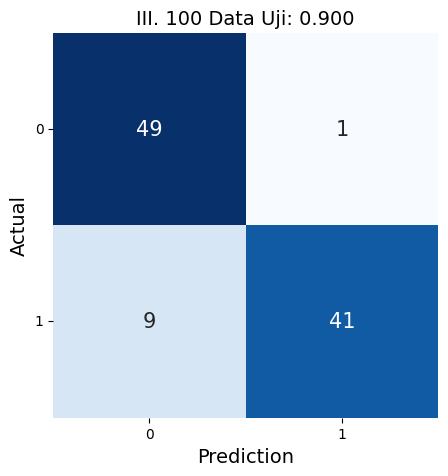

In [ ]:
plt.figure(figsize=(8, 5))
labels = np.unique(y_test)
cm = confusion_matrix(y_test, model_nb.predict(X_test), labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels,
            fmt="d", annot_kws={"fontsize": 15})
plt.title(f'III. 100 Data Uji: {model_nb.score(X_test, y_test):.3f}',fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center');

In [6]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [7]:
print("Train report")
print(classification_report(y_train, gnb.predict(X_train)))
print()
print("Test report")
print(classification_report(y_test, gnb.predict(X_test)))

Train report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       1.00      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400


Test report
              precision    recall  f1-score   support

           0       0.95      0.70      0.80        50
           1       0.76      0.96      0.85        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



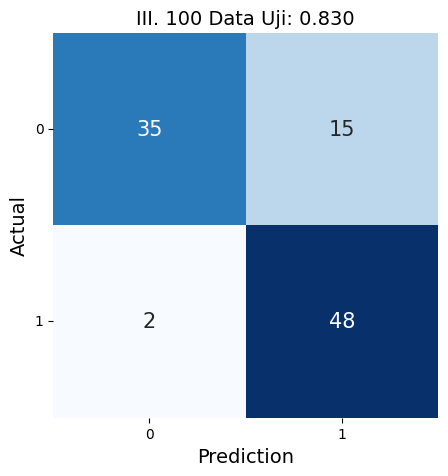

In [8]:
plt.figure(figsize=(8, 5))
labels = np.unique(y_test)
cm = confusion_matrix(y_test, gnb.predict(X_test), labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels,
            fmt="d", annot_kws={"fontsize": 15})
plt.title(f'III. 100 Data Uji: {gnb.score(X_test, y_test):.3f}',fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center');

In [ ]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('svc', SVC())
])

model_svc = GridSearchCV(pipeline, params_svc, cv=cv_method, n_jobs=-1, verbose=1)
model_svc.fit(X_train, y_train)

print(model_svc.best_params_)
print(model_svc.score(X_train, y_train), model_svc.best_score_, model_svc.score(X_test, y_test))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'sigmoid', 'svc__probability': True}
0.985 0.8625 0.88


In [ ]:
pd.DataFrame(model_svc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,param_svc__probability,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,53.826280,4.206782,0.994980,0.243360,0.1,1,rbf,True,"{'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'rbf', 'svc__probability': True}",0.550,...,0.550,0.550,0.575,0.550,0.575,0.575,0.525,0.5550,0.018708,38
1,49.914108,0.450377,0.924369,0.154945,0.1,1,poly,True,"{'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'poly', 'svc__probability': True}",0.625,...,0.675,0.675,0.500,0.650,0.725,0.650,0.625,0.6300,0.058949,21
2,49.224332,0.455118,0.911217,0.193538,0.1,1,sigmoid,True,"{'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'sigmoid', 'svc__probability': True}",0.600,...,0.575,0.475,0.675,0.625,0.550,0.675,0.475,0.5825,0.068053,27
3,50.100422,0.551882,0.958911,0.123598,0.1,0.1,rbf,True,"{'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__probability': True}",0.525,...,0.525,0.500,0.575,0.475,0.575,0.575,0.525,0.5275,0.036142,40
4,49.372333,0.573434,0.875475,0.105451,0.1,0.1,poly,True,"{'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'poly', 'svc__probability': True}",0.550,...,0.625,0.575,0.500,0.550,0.600,0.575,0.600,0.5700,0.033166,29
5,48.825007,0.593455,0.882368,0.170307,0.1,0.1,sigmoid,True,"{'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid', 'svc__probability': True}",0.850,...,0.750,0.850,0.825,0.825,0.850,0.850,0.825,0.8275,0.030516,8
6,50.791639,1.589875,1.007432,0.190040,0.1,0.01,rbf,True,"{'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf', 'svc__probability': True}",0.800,...,0.650,0.775,0.650,0.625,0.750,0.600,0.700,0.7025,0.064663,15
7,49.782258,0.938582,0.826831,0.041937,0.1,0.01,poly,True,"{'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kernel': 'poly', 'svc__probability': True}",0.500,...,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.5000,0.000000,44
8,48.840884,0.475529,0.952929,0.171252,0.1,0.01,sigmoid,True,"{'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kernel': 'sigmoid', 'svc__probability': True}",0.575,...,0.600,0.625,0.500,0.575,0.650,0.575,0.675,0.5950,0.045826,26
9,49.905203,0.782310,1.035530,0.215686,0.1,0.001,rbf,True,"{'svc__C': 0.1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf', 'svc__probability': True}",0.550,...,0.600,0.550,0.475,0.575,0.625,0.550,0.625,0.5700,0.041533,29


In [ ]:
model_svc.score(X_test, y_test)

0.88

In [ ]:
print("Train report")
print(classification_report(y_train, model_svc.predict(X_train)))
print()
print("Test report")
print(classification_report(y_test, model_svc.predict(X_test)))

Train report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       200
           1       1.00      0.97      0.98       200

    accuracy                           0.98       400
   macro avg       0.99      0.98      0.98       400
weighted avg       0.99      0.98      0.98       400


Test report
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        50
           1       1.00      0.76      0.86        50

    accuracy                           0.88       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.88      0.88       100



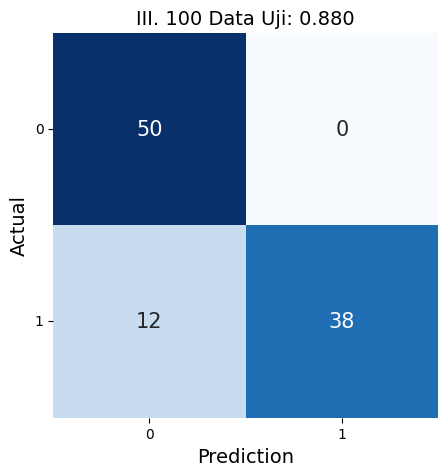

In [ ]:
plt.figure(figsize=(8, 5))
labels = np.unique(y_test)
cm = confusion_matrix(y_test, model_svc.predict(X_test), labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels,
            fmt="d", annot_kws={"fontsize": 15})
plt.title(f'III. 100 Data Uji: {model_svc.score(X_test, y_test):.3f}',fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center');

In [9]:
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [12]:
print("Train report")
print(classification_report(y_train, svm.predict(X_train)))
print()
print("Test report")
print(classification_report(y_test, svm.predict(X_test)))

Train report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Test report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        50
           1       0.96      0.90      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



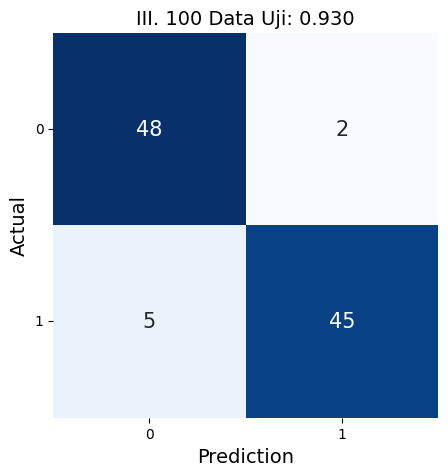

In [11]:
plt.figure(figsize=(8, 5))
labels = np.unique(y_test)
cm = confusion_matrix(y_test, svm.predict(X_test), labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels,
            fmt="d", annot_kws={"fontsize": 15})
plt.title(f'III. 100 Data Uji: {svm.score(X_test, y_test):.3f}',fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center');

In [4]:
model_nb = pickle.load(open('/content/drive/MyDrive/model_nb.sav', 'rb'))
model_svc = pickle.load(open('/content/drive/MyDrive/model_svc.sav', 'rb'))

Text(0, 0.5, 'Akurasi')

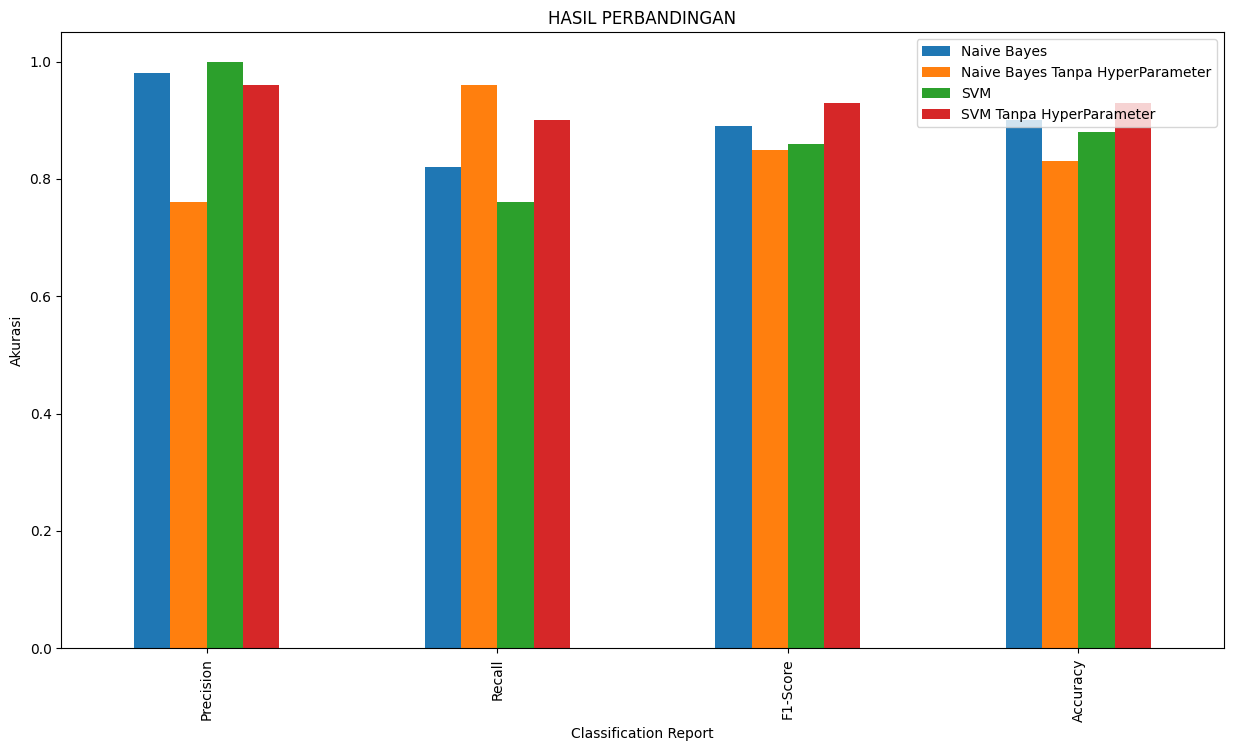

In [37]:
plotdata = pd.DataFrame({

    "Naive Bayes":[0.98, 0.82, 0.89, 0.90],

    "Naive Bayes Tanpa HyperParameter":[0.76, 0.96, 0.85, 0.83],

    "SVM":[1.00, 0.76, 0.86, 0.88],

    "SVM Tanpa HyperParameter":[0.96, 0.90, 0.93, 0.93]},

    index=["Precision", "Recall", "F1-Score", "Accuracy"])

plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("HASIL PERBANDINGAN")

plt.xlabel("Classification Report")

plt.ylabel("Akurasi")

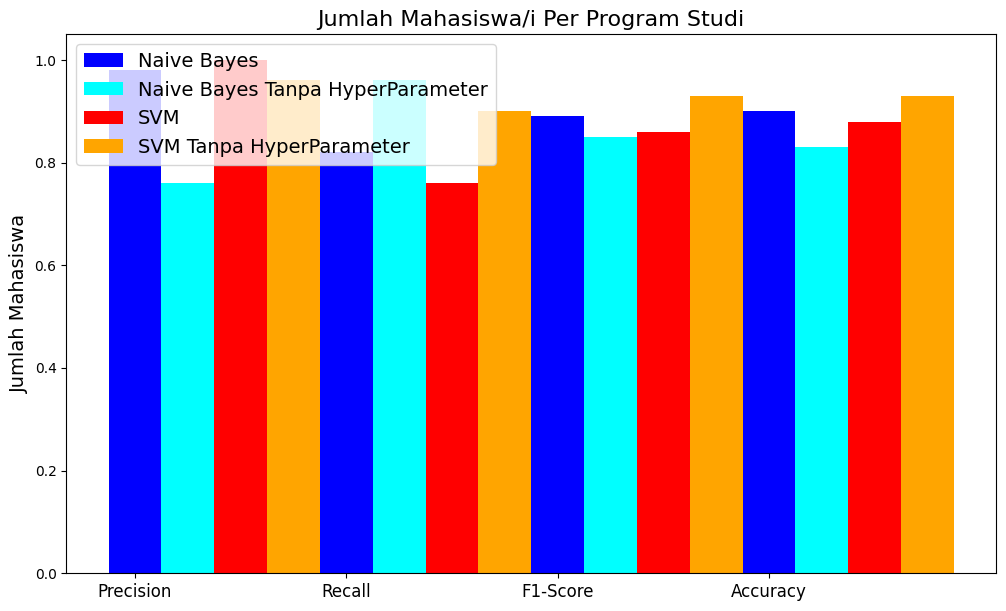

In [33]:
perbandingan = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
nba = [0.98, 0.82, 0.89, 0.90]
nb_t = [0.76, 0.96, 0.85, 0.83]
svma = [1.00, 0.76, 0.86, 0.88]
svm_t =[0.96, 0.90, 0.93, 0.93]

x = np.arange(len(perbandingan))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))

mhs = ax.bar(x , nba, width, label='Naive Bayes', color='blue')
mhs1 = ax.bar(x + width, nb_t, width, label='Naive Bayes Tanpa HyperParameter', color='cyan')
mhs2 = ax.bar(x + width*2, svma, width, label='SVM', color='red')
mhs3 = ax.bar(x + width*3, svm_t, width, label='SVM Tanpa HyperParameter', color='orange')

ax.set_title('Jumlah Mahasiswa/i Per Program Studi', size=16)
ax.set_ylabel('Jumlah Mahasiswa', size=14)
ax.set_xticks(x)
ax.set_xticklabels(perbandingan, size=12)
ax.legend(fontsize=14)

plt.show()